Episode: 0, Energy: 20.73, Reward: 129.27, Tasks Completed: 20/20
Episode: 1, Energy: 20.41, Reward: 129.59, Tasks Completed: 20/20
Episode: 2, Energy: 24.39, Reward: 125.61, Tasks Completed: 20/20
Episode: 3, Energy: 21.15, Reward: 128.85, Tasks Completed: 20/20
Episode: 4, Energy: 26.86, Reward: 123.14, Tasks Completed: 20/20
Episode: 5, Energy: 22.20, Reward: 127.80, Tasks Completed: 20/20
Episode: 6, Energy: 27.55, Reward: 122.45, Tasks Completed: 20/20
Episode: 7, Energy: 22.51, Reward: 127.49, Tasks Completed: 20/20
Episode: 8, Energy: 27.03, Reward: 122.97, Tasks Completed: 20/20
Episode: 9, Energy: 26.65, Reward: 123.35, Tasks Completed: 20/20
Episode: 10, Energy: 23.06, Reward: 126.94, Tasks Completed: 20/20
Episode: 11, Energy: 25.54, Reward: 124.46, Tasks Completed: 20/20
Episode: 12, Energy: 23.91, Reward: 126.09, Tasks Completed: 20/20
Episode: 13, Energy: 24.38, Reward: 125.62, Tasks Completed: 20/20
Episode: 14, Energy: 25.30, Reward: 124.70, Tasks Completed: 20/20
Episo

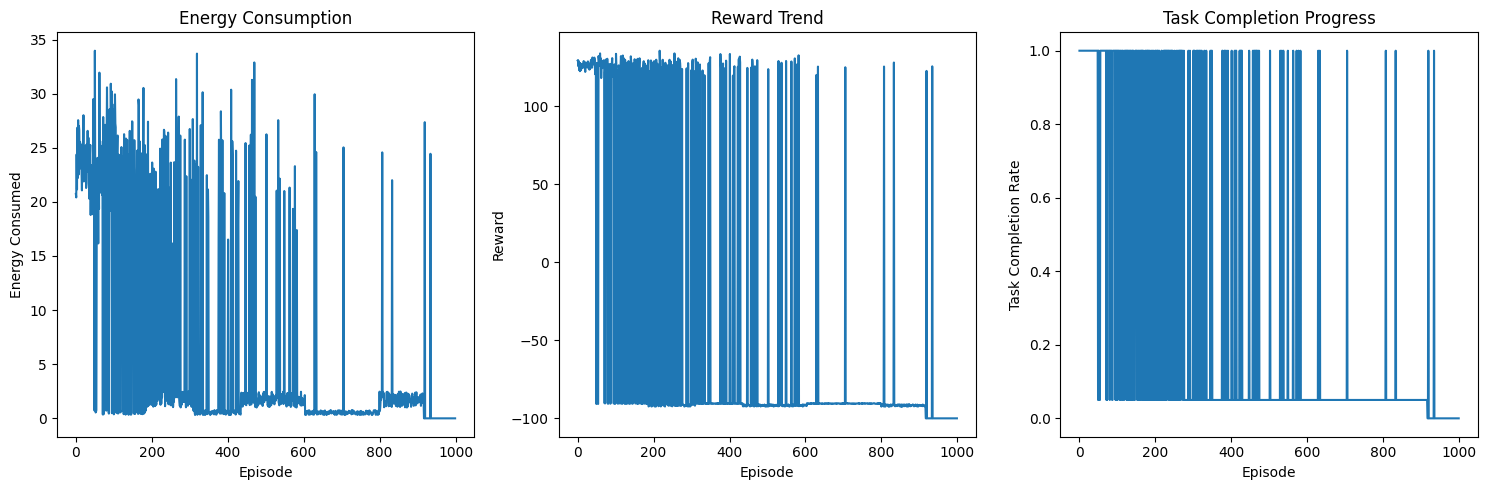

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# -------------------------------
# SumTree for Prioritized Replay
# -------------------------------
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.data_pointer = 0

    def add(self, priority, data):
        index = self.data_pointer + self.capacity - 1
        self.data[self.data_pointer] = data
        self.update(index, priority)
        self.data_pointer = (self.data_pointer + 1) % self.capacity

    def update(self, index, priority):
        change = priority - self.tree[index]
        self.tree[index] = priority
        while index != 0:
            index = (index - 1) // 2
            self.tree[index] += change

    def get_leaf(self, value):
        parent_idx = 0
        while True:
            left_child = 2 * parent_idx + 1
            right_child = left_child + 1
            if left_child >= len(self.tree):
                leaf_idx = parent_idx
                break
            if value <= self.tree[left_child]:
                parent_idx = left_child
            else:
                value -= self.tree[left_child]
                parent_idx = right_child
        data_index = leaf_idx - self.capacity + 1
        return leaf_idx, self.tree[leaf_idx], self.data[data_index]

    def total_priority(self):
        return self.tree[0]

    def size(self):
        return min(self.capacity, self.data_pointer)

# -------------------------------------------
# Mobile Edge Computing Environment (MECEnv)
# -------------------------------------------
class MECEnvironment:
    def __init__(self, num_md, num_es, num_tasks):
        self.num_md = num_md      # number of mobile devices
        self.num_es = num_es      # number of edge servers
        self.num_tasks = num_tasks

        # These parameters are set once:
        self.md_compute = np.random.uniform(1.0, 2.5, num_md)     # GHz (mobile compute capacity)
        self.es_compute = np.random.uniform(10.0, 15.0, num_es)     # GHz (edge compute capacity)
        self.task_requirements = np.random.uniform(1.0, 5.0, num_tasks)  # Compute requirement (c_k)
        self.task_to_md = np.random.randint(0, num_md, num_tasks)   # Pre-assign each task to a mobile device
        
        self.reset()

    def reset(self):
        # Reset battery levels for mobile devices and edge servers.
        self.md_battery = np.random.uniform(3000, 5000, self.num_md)  # mAh for mobiles
        self.es_battery = np.random.uniform(10000, 20000, self.num_es)  # mAh for edge servers
        
        # Generate tasks. Each task has:
        #   - a duration factor (δ_k) drawn uniformly between 2.0 and 5.0,
        #   - a compute requirement (c_k) (pre-determined).
        self.tasks = np.column_stack([
            np.random.uniform(2.0, 5.0, self.num_tasks),  # δ_k
            self.task_requirements                        # c_k
        ])
        # Instead of keeping tasks pending, we assume each task is attempted once.
        # We'll mark a task as completed (True) only if it finishes.
        self.task_status = np.zeros(self.num_tasks, dtype=bool)
        
        # Episode counters.
        self.completed_tasks = 0
        self.total_energy_consumed = 0
        self.constraint_violations = 0
        
        return self._get_state()

    def _get_state(self):
        # The state is a normalized vector containing:
        # - Mobile device battery levels,
        # - Edge server battery levels,
        # - Mobile and edge compute capacities,
        # - Task parameters (δ_k and c_k),
        # - Task completion status (0.0 for unfinished, 1.0 for completed).
        return np.concatenate([
            self.md_battery / 5000,
            self.es_battery / 20000,
            self.md_compute / 2.5,
            self.es_compute / 15.0,
            self.tasks[:, 0] / 5.0,  # normalized δ_k
            self.tasks[:, 1] / 5.0,  # normalized c_k
            self.task_status.astype(float)
        ])

    def step(self, action):
        """
        In one step (i.e. one episode), the agent assigns each task (via the 'action' vector)
        to either be processed locally (0) or offloaded (1). Each task is attempted once.
        
        - If the selected device has enough battery, the task is completed.
        - Otherwise, a violation occurs, the device battery is drained (set to 0), and
          the task remains unfinished.
        """
        tasks_completed_in_episode = 0

        # Process each task one by one.
        for task_idx, a in enumerate(action):
            # a must be 0 (local) or 1 (offload)
            if a not in {0, 1}:
                continue

            # For each task, we attempt it once.
            if a == 0:  # Local processing on mobile device
                md_idx = self.task_to_md[task_idx]
                t = self.tasks[task_idx, 0] / self.md_compute[md_idx]
                e = t * (1.01 + 0.08 * (md_idx % 3))  # Energy required
                if self.md_battery[md_idx] < e:
                    # Not enough battery: record violation, drain battery.
                    self.constraint_violations += 1
                    self.total_energy_consumed += self.md_battery[md_idx]
                    self.md_battery[md_idx] = 0
                    # Task remains unfinished.
                else:
                    # Sufficient battery: complete task.
                    self.md_battery[md_idx] -= e
                    self.total_energy_consumed += e
                    self.task_status[task_idx] = True
                    tasks_completed_in_episode += 1

            else:  # Offload to an edge server
                es_idx = task_idx % self.num_es  # Simple round-robin selection.
                t = self.tasks[task_idx, 0] / self.es_compute[es_idx]
                e_server = t * (0.61 + 0.08 * (es_idx % 3))
                e_transmit = self.tasks[task_idx, 0] * 0.1
                total_e = e_server + e_transmit
                if self.es_battery[es_idx] < total_e:
                    self.constraint_violations += 1
                    self.total_energy_consumed += self.es_battery[es_idx]
                    self.es_battery[es_idx] = 0
                    # Task remains unfinished.
                else:
                    self.es_battery[es_idx] -= total_e
                    self.total_energy_consumed += total_e
                    self.task_status[task_idx] = True
                    tasks_completed_in_episode += 1

        self.completed_tasks = np.sum(self.task_status)
        unfinished_tasks = self.num_tasks - self.completed_tasks  # Tasks that were not completed

        # ----------------------------------
        # Reward Calculation:
        # ----------------------------------
        # 1. For every completed task: +5 reward.
        task_bonus = 5 * self.completed_tasks
        # 2. For every unfinished task: -5 penalty.
        unfinished_penalty = -5 * unfinished_tasks
        # 3. If all tasks are completed, add an extra bonus of +50.
        completion_bonus = 50 if unfinished_tasks == 0 else 0
        # 4. Energy penalty: subtract total energy consumed (1-to-1).
        energy_penalty = self.total_energy_consumed
        # 5. Constraint penalty: -25 for every device that is fully discharged.
        discharged_md = np.sum(self.md_battery == 0)
        discharged_es = np.sum(self.es_battery == 0)
        constraint_penalty = -25 * (discharged_md + discharged_es)

        reward = task_bonus + unfinished_penalty + completion_bonus - energy_penalty + constraint_penalty

        # One-step episode: after processing all tasks, the episode ends.
        done = True

        return self._get_state(), reward, done

# DQN Agent with Prioritized Replay
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = SumTree(10000)
        self.batch_size = 32
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(24, activation='relu', input_shape=(self.state_size,)),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            # Return a random binary action for each task.
            return np.random.randint(0, 2, self.action_size)
        q_values = self.model.predict(state.reshape(1, -1), verbose=0)
        # For simplicity, we choose the action with maximum Q-value per task.
        return np.argmax(q_values, axis=1)

    def remember(self, state, action, reward, next_state, done):
        q_values = self.model.predict(state.reshape(1, -1), verbose=0)
        next_q_values = self.target_model.predict(next_state.reshape(1, -1), verbose=0)
        td_error = abs(reward + self.gamma * np.max(next_q_values) - q_values[0][action]).mean()
        self.memory.add(td_error + 1e-5, (state, action, reward, next_state, done))

    def replay(self):
        if self.memory.size() < self.batch_size:
            return
        total_priority = self.memory.total_priority()
        segment = total_priority / self.batch_size
        batch = []
        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            value = np.random.uniform(a, b)
            index, priority, data = self.memory.get_leaf(value)
            batch.append(data)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = np.array(states)
        next_states = np.array(next_states)
        q_values = self.model.predict(states, verbose=0)
        next_q_values = self.target_model.predict(next_states, verbose=0)
        for i in range(self.batch_size):
            if dones[i]:
                q_values[i][actions[i]] = rewards[i]
            else:
                q_values[i][actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])
        self.model.fit(states, q_values, batch_size=self.batch_size, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


state_size = (10 + 4) + (10 + 4) + (20 * 3)  # = 14 + 14 + 60 = 88
action_size = 20  

env = MECEnvironment(num_md=10, num_es=4, num_tasks=20)
agent = DQNAgent(state_size=state_size, action_size=action_size)

# Tracking metrics
energy_history = []
reward_history = []
task_completion_history = []

# Since each episode is one step (all tasks are processed once), we run one step per episode.
for episode in range(1000):
    state = env.reset()
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    agent.remember(state, action, reward, next_state, done)
    agent.replay()

    energy_history.append(env.total_energy_consumed)
    reward_history.append(reward)
    task_completion_history.append(env.completed_tasks / env.num_tasks)

    print(f"Episode: {episode}, Energy: {env.total_energy_consumed:.2f}, Reward: {reward:.2f}, Tasks Completed: {env.completed_tasks}/{env.num_tasks}")

# Plot the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(energy_history)
plt.xlabel("Episode")
plt.ylabel("Energy Consumed")
plt.title("Energy Consumption")

plt.subplot(1, 3, 2)
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward Trend")

plt.subplot(1, 3, 3)
plt.plot(task_completion_history)
plt.xlabel("Episode")
plt.ylabel("Task Completion Rate")
plt.title("Task Completion Progress")

plt.tight_layout()
plt.show()
